In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt


In [ ]:
def data_preproc(csv_file, lag = 15, forecast = 5):
    # Load & sort chronologically
    df = pd.read_csv(csv_file, parse_dates=['Date'])
    df.sort_values('Date', inplace=True)

    feature_cols = ["Open", "High", "Low", "Close", "Volume"]

    # Create lag features
    for i in range(1, lag + 1):
        for col in feature_cols:
            df[f"{col}_lag{i}"] = df[col].shift(i)

    # Create target (Close price `forecast` days ahead)
    df["target"] = df["Close"].shift(-forecast)

    # Drop rows containing NaNs produced by shifting
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # assemble X, y
    lag_feature_cols = [f"{col}_lag{i}" for i in range(1, lag + 1) for col in feature_cols]
    X = df[lag_feature_cols]
    y = df["target"]
    dates = df["Date"] 

    return X, y, dates

In [ ]:
def split_data(X, y, dates, train_ratio = 0.70, val_ratio = 0.15):
    # Chronological train / val / test split (70/15/15)
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]
    d_test = dates.iloc[val_end:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test, d_test)

In [4]:
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

In [ ]:
def run_dnn(csv_file, lag = 15, forecast = 5,
            hidden_layers = (128,64),
            max_iter = 250):
        # Data Preprocessing
        X, y, dates = data_preproc(csv_file, lag, forecast)

        # Chronological train / val / test split (70/15/15)
        (X_train, y_train), (X_val, y_val), (X_test, y_test, d_test) = split_data(X, y, dates)
        
        # Scale data    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled   = scaler.transform(X_val)
        X_test_scaled  = scaler.transform(X_test)

        # Fit model to DNN and evaluate predictions
        model = MLPRegressor(
                hidden_layer_sizes = hidden_layers,
                activation = 'relu',
                solver = 'adam',
                max_iter = max_iter,
                batch_size = 256,
                random_state = 98,
                verbose = True,
        )
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        metrics = {
                "Train": eval_metrics(y_train, y_train_pred),
                "Validation": eval_metrics(y_val, y_val_pred),
                "Test": eval_metrics(y_test, y_test_pred)
        }
    
        return metrics, model, d_test.reset_index(drop=True), y_test.reset_index(drop=True), y_test_pred

Iteration 1, loss = 5743.88210222
Validation score: -11.693414
Iteration 2, loss = 5315.68059691
Validation score: -10.334832
Iteration 3, loss = 4523.84480313
Validation score: -7.946733
Iteration 4, loss = 3353.48091588
Validation score: -4.862091
Iteration 5, loss = 2132.36039313
Validation score: -2.397828
Iteration 6, loss = 1437.95118728
Validation score: -1.745105
Iteration 7, loss = 1298.65650974
Validation score: -1.557335
Iteration 8, loss = 1189.49432806
Validation score: -1.312892
Iteration 9, loss = 1071.99972233
Validation score: -1.068490
Iteration 10, loss = 950.83537570
Validation score: -0.841573
Iteration 11, loss = 838.95722681
Validation score: -0.651182
Iteration 12, loss = 748.78522578
Validation score: -0.512187
Iteration 13, loss = 679.72682969
Validation score: -0.402747
Iteration 14, loss = 627.09573513
Validation score: -0.322438
Iteration 15, loss = 586.02346462
Validation score: -0.252213
Iteration 16, loss = 549.21152716
Validation score: -0.193825
Iterat

,MSE,RMSE,MAE,R²
Train,8.436014,2.904482,2.076385,0.991259
Validation,188.417114,13.726511,9.962662,0.726489
Test,5092.286997,71.360262,64.940426,-3.629279


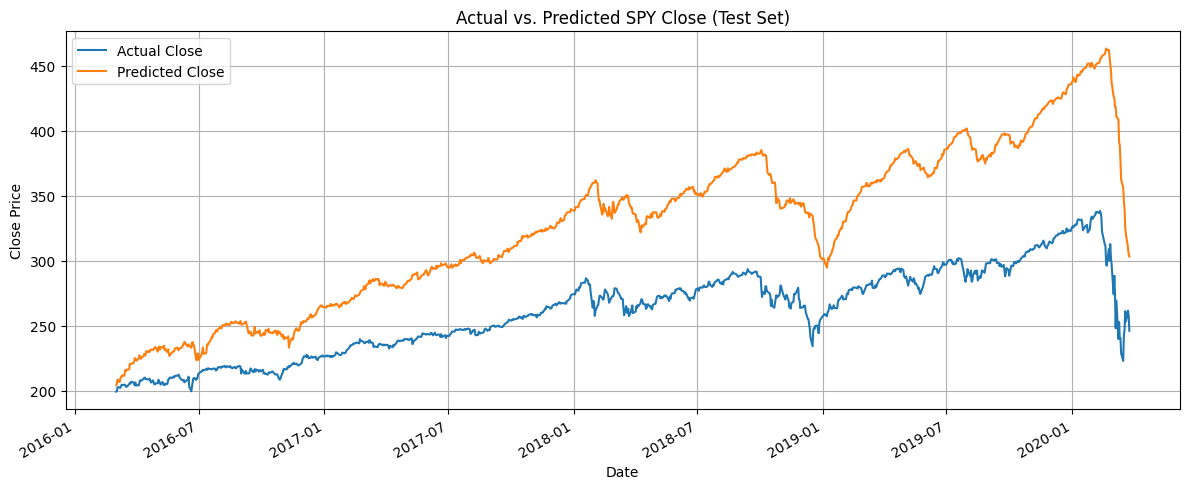

In [54]:
# Visualize results
metrics, model, dates_test, y_test, y_pred_test = run_dnn('../data/etfs/SPY.csv')
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
display(df_metrics)

actual = pd.Series(y_test.values, index=dates_test, name='Actual Close')
pred   = pd.Series(y_pred_test,       index=dates_test, name='Predicted Close')
plot_df = pd.concat([actual, pred], axis=1)

ax = plot_df.plot(figsize=(12,5), grid=True)
ax.set_title("Actual vs. Predicted SPY Close (Test Set)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
plt.tight_layout()
plt.show()